# **Homework 3 - Convolutional Neural Network**

This is the example code of homework 3 of the machine learning course by Prof. Hung-yi Lee.

In this homework, you are required to build a convolutional neural network for image classification, possibly with some advanced training tips.


There are three levels here:

**Easy**: Build a simple convolutional neural network as the baseline. (2 pts)

**Medium**: Design a better architecture or adopt different data augmentations to improve the performance. (2 pts)

**Hard**: Utilize provided unlabeled data to obtain better results. (2 pts)

## **About the Dataset**

The dataset used here is food-11, a collection of food images in 11 classes.

For the requirement in the homework, TAs slightly modified the data.
Please DO NOT access the original fully-labeled training data or testing labels.

Also, the modified dataset is for this course only, and any further distribution or commercial use is forbidden.

In [1]:
# # Download the dataset
# # You may choose where to download the data.

# # Google Drive
# !gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip

# # Dropbox
# # !wget https://www.dropbox.com/s/m9q6273jl3djall/food-11.zip -O food-11.zip

# # MEGA
# # !sudo apt install megatools
# # !megadl "https://mega.nz/#!zt1TTIhK!ZuMbg5ZjGWzWX1I6nEUbfjMZgCmAgeqJlwDkqdIryfg"

# # Unzip the dataset.
# # This may take some time.
# !unzip -q food-11.zip

## **Import Packages**

First, we need to import packages that will be used later.

In this homework, we highly rely on **torchvision**, a library of PyTorch.

In [2]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

# This is for the progress bar.
# from tqdm.auto import tqdm

## **Dataset, Data Loader, and Transforms**

Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply **torchvision.datasets.DatasetFolder** for wrapping data without much effort.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.

In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    transforms.RandomApply([
#         transforms.ColorJitter(hue=0.5),
#         transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 5)),
#          transforms.RandomPosterize(bits=2),
         transforms.RandomAdjustSharpness(sharpness_factor=2),
         transforms.RandomAutocontrast(),
         transforms.RandomRotation(20),
        ], p=0.4),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])
train_tfm_flip = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomApply([
#         transforms.ColorJitter(hue=0.5),
# #         transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 5)),
#         transforms.RandomPosterize(bits=2),
        transforms.RandomAdjustSharpness(sharpness_factor=2),
        transforms.RandomAutocontrast(),
        transforms.RandomRotation(20),
    ], p=0.4),
    transforms.ToTensor(),
])
train_tfm_rotate = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(15),
    transforms.RandomApply([
#         transforms.ColorJitter(hue=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 5)),
#         transforms.RandomPosterize(bits=2),
        transforms.RandomAdjustSharpness(sharpness_factor=2),
        transforms.RandomAutocontrast(),
#         transforms.RandomRotation(15),
    ], p=0.4),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


In [4]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 128

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set_0 = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
train_set_1 = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm_flip)
train_set_2 = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm_rotate)
valid_set = DatasetFolder("food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
test_set = DatasetFolder("food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

train_set = ConcatDataset([train_set_0, Subset(train_set_1, range(280*0, 280*1)), train_set_2])

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

## **Model**

The basic model here is simply a stack of convolutional layers followed by some fully-connected layers.

Since there are three channels for a color image (RGB), the input channels of the network must be three.
In each convolutional layer, typically the channels of inputs grow, while the height and width shrink (or remain unchanged, according to some hyperparameters like stride and padding).

Before fed into fully-connected layers, the feature map must be flattened into a single one-dimensional vector (for each image).
These features are then transformed by the fully-connected layers, and finally, we obtain the "logits" for each class.

### **WARNING -- You Must Know**
You are free to modify the model architecture here for further improvement.
However, if you want to use some well-known architectures such as ResNet50, please make sure **NOT** to load the pre-trained weights.
Using such pre-trained models is considered cheating and therefore you will be punished.
Similarly, it is your responsibility to make sure no pre-trained weights are used if you use **torch.hub** to load any modules.

For example, if you use ResNet-18 as your model:

model = torchvision.models.resnet18(pretrained=**False**) → This is fine.

model = torchvision.models.resnet18(pretrained=**True**)  → This is **NOT** allowed.

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 128, 128]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Dropout(p=0.2),

            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Dropout(p=0.1),
            
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Dropout(p=0.1),
            
            nn.Conv2d(64, 128, 3, 1, 1),
#             nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Dropout(p=0.1),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(16, 11),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

## **Training**

You can finish supervised learning by simply running the provided code without any modification.

The function "get_pseudo_labels" is used for semi-supervised learning.
It is expected to get better performance if you use unlabeled data for semi-supervised learning.
However, you have to implement the function on your own and need to adjust several hyperparameters manually.

For more details about semi-supervised learning, please refer to [Prof. Lee's slides](https://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/semi%20(v3).pdf).

Again, please notice that utilizing external data (or pre-trained model) for training is **prohibited**.

In [6]:
class PseudoDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id], self.y[id]

In [7]:
def get_pseudo_labels(dataset, model, threshold=0.65):
    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Make sure the model is in eval mode.
    model.eval()
    
    masked_data_list = []
    masked_label_list = []
    # Iterate over the dataset by batches.
    for i, batch in enumerate(data_loader):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        max_info = torch.max(logits, dim=1)

        # ---------- TODO ----------
        # Filter the data and construct a new dataset.
        masked_data_list.append(img[max_info.values>threshold])
        masked_label_list.append(max_info.indices[max_info.values>threshold])

    # # Turn off the eval mode.
    model.train()
    return PseudoDataset(torch.cat(masked_data_list), torch.cat(masked_label_list).cpu().numpy())

In [8]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device
model_path = 'model.pth'
model.load_state_dict(torch.load(model_path))

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, weight_decay=1e-3)

# The number of training epochs.
n_epochs = 50

# Whether to do semi-supervised learning.
do_semi = False

best_acc = 0.0
train_loss_record = []
valid_loss_record = []
train_acc_record = []
valid_acc_record = []

# if do_semi:
#     # Obtain pseudo-labels for unlabeled data using trained model.
#     pseudo_set = get_pseudo_labels(unlabeled_set, model)

#     # Construct a new dataset and a data loader for training.
#     # This is used in semi-supervised learning only.
#     concat_dataset = ConcatDataset([train_set, pseudo_set])
#     train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

for epoch in range(n_epochs):
    # ---------- TODO ----------
    # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
    # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.

    if epoch == 100:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in train_loader:

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}", end='\t')

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in valid_loader:

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    if valid_acc > best_acc:
        best_acc = valid_acc
        print('save model')
        torch.save(model.state_dict(), model_path)
        if do_semi and epoch > 10:
            # Obtain pseudo-labels for unlabeled data using trained model.
            pseudo_set = get_pseudo_labels(unlabeled_set, model)

            # Construct a new dataset and a data loader for training.
            # This is used in semi-supervised learning only.
            concat_dataset = ConcatDataset([train_set, pseudo_set])
            train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    train_loss_record.append(train_loss)
    valid_loss_record.append(valid_loss)
    train_acc_record.append(train_acc.cpu())
    valid_acc_record.append(valid_acc.cpu())

/opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[ Train | 001/050 ] loss = 1.59000, acc = 0.96605	[ Valid | 001/050 ] loss = 1.93764, acc = 0.58177
save model
[ Train | 002/050 ] loss = 1.58808, acc = 0.97044	[ Valid | 002/050 ] loss = 1.95133, acc = 0.57005
[ Train | 003/050 ] loss = 1.59058, acc = 0.96513	[ Valid | 003/050 ] loss = 1.94250, acc = 0.56823
[ Train | 004/050 ] loss = 1.58564, acc = 0.97528	[ Valid | 004/050 ] loss = 1.93872, acc = 0.60781
save model
[ Train | 005/050 ] loss = 1.58933, acc = 0.96915	[ Valid | 005/050 ] loss = 1.94020, acc = 0.57865
[ Train | 006/050 ] loss = 1.58798, acc = 0.96924	[ Valid | 006/050 ] loss = 1.92398, acc = 0.60469
[ Train | 007/050 ] loss = 1.58886, acc = 0.96850	[ Valid | 007/050 ] loss = 1.93497, acc = 0.58516
[ Train | 008/050 ] loss = 1.58675, acc = 0.97408	[ Valid | 008/050 ] loss = 1.97096, acc = 0.55234
[ Train | 009/050 ] loss = 1.59043, acc = 0.96556	[ Valid | 009/050 ] loss = 1.91729, acc = 0.59714
[ Train | 010/050 ] loss = 1.58807, acc = 0.97074	[ Valid | 010/050 ] loss = 1

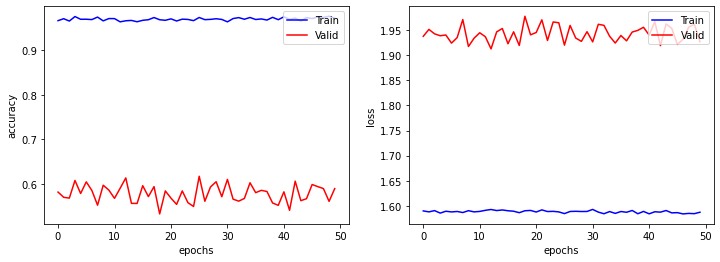

In [9]:
import matplotlib.pyplot as plt

x = np.arange(len(train_acc_record))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x, train_acc_record, color="blue", label="Train")
plt.plot(x, valid_acc_record, color="red", label="Valid")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc="upper right")

plt.subplot(1, 2, 2)
plt.plot(x, train_loss_record, color="blue", label="Train")
plt.plot(x, valid_loss_record, color="red", label="Valid")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc="upper right") 

plt.show()

### anylze accuracy

In [10]:
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [11]:
val_prediction = np.zeros(shape=len(valid_set))
val_label = np.zeros(shape=len(valid_set))
for i, batch in enumerate(valid_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch

    # We don't need gradient in validation.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs.to(device))
    
    val_prediction[i*len(labels):(i+1)*len(labels)] = logits.argmax(dim=-1).cpu().numpy()
    val_label[i*len(labels):(i+1)*len(labels)] = labels

Text(33.0, 0.5, 'real label')

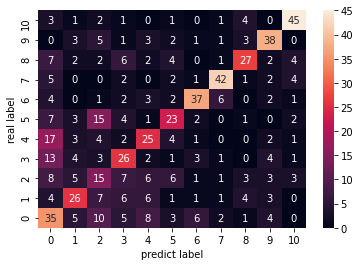

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

val_materix = confusion_matrix(val_label, val_prediction)
sns.heatmap(val_materix, annot=True).invert_yaxis()
plt.xlabel('predict label')
plt.ylabel('real label')

## **Testing**

For inference, we need to make sure the model is in eval mode, and the order of the dataset should not be shuffled ("shuffle=False" in test_loader).

Last but not least, don't forget to save the predictions into a single CSV file.
The format of CSV file should follow the rules mentioned in the slides.

### **WARNING -- Keep in Mind**

Cheating includes but not limited to:
1.   using testing labels,
2.   submitting results to previous Kaggle competitions,
3.   sharing predictions with others,
4.   copying codes from any creatures on Earth,
5.   asking other people to do it for you.

Any violations bring you punishments from getting a discount on the final grade to failing the course.

It is your responsibility to check whether your code violates the rules.
When citing codes from the Internet, you should know what these codes exactly do.
You will **NOT** be tolerated if you break the rule and claim you don't know what these codes do.


In [13]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in test_loader:
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

In [14]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")